# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
from time import time
import pprint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib

# Read the data from csv file

In [2]:
arrhyData=pd.read_csv('Arrhythmia cleaned data.csv')
arrhyData01=arrhyData.copy()
X=arrhyData01.drop(labels=['label'],axis=1)
#stanardilization
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=arrhyData01['label'].values


# Explore the best score PCA got for each classifier

## PCA----Light GBM

### Searching the best score 

(350, 278)
(88, 278)
PCA begin with n_components: 0.5
accuracy: 0.6477272727272727, time elaps:0
PCA begin with n_components: 0.5321428571428571
accuracy: 0.625, time elaps:0
PCA begin with n_components: 0.5642857142857143
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.5964285714285714
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.6285714285714286
accuracy: 0.6477272727272727, time elaps:0
PCA begin with n_components: 0.6607142857142857
accuracy: 0.6590909090909091, time elaps:0
PCA begin with n_components: 0.6928571428571428
accuracy: 0.6477272727272727, time elaps:0
PCA begin with n_components: 0.725
accuracy: 0.6590909090909091, time elaps:0
PCA begin with n_components: 0.7571428571428571
accuracy: 0.6022727272727273, time elaps:0
PCA begin with n_components: 0.7892857142857143
accuracy: 0.5909090909090909, time elaps:0
PCA begin with n_components: 0.8214285714285714
accuracy: 0.6022727272727273, time elaps:0
PCA begin with n_co

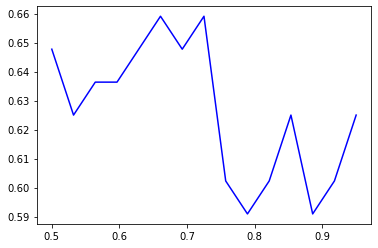

In [3]:
import time
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size = 0.8,shuffle=True,stratify=y,random_state=42)

print(X_train.shape)
print(X_test.shape) 

def n_component_analysis(n, X, y_train, X_test, y_test):
    start = time.time()
    
    pca = PCA(n_components=n)
    print("PCA begin with n_components: {}".format(n));
    pca.fit(X_train)    
    # Dimensionality reduction in training and test sets
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
#    training at Light GBM
    clf1 = LGBMClassifier()
    clf1.fit(X_train_pca, y_train)

    accuracy = clf1.score(X_test_pca, y_test)
    
    end = time.time()
    print("accuracy: {}, time elaps:{}".format(accuracy, int(end-start)))
    return accuracy 
 
# set the search range for PCA
n_s = np.linspace(0.50, 0.95, num=15)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n, X_train, y_train, X_test, y_test)
    accuracy.append(tmp)    
    
print(max(accuracy), (accuracy.index(max(accuracy))*1)+1)    
# Plot the performance of the model under different PCA dimensions and find the best model/parameters (highest score)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_s, np.array(accuracy), 'b-')

### Verify the dimensionality of the PCA with the best score

In [4]:

pca = PCA(n_components=0.66)
 
#According to the best parameters, retrain the model on the entire training data
pca.fit(X_train) 
pca.n_components_
 
#According to the best parameters, reduce the dimensionality of the entire training data
X_train_pca = pca.transform(X_train) 
#According to the best parameters, reduce the dimension of the test data
X_test_pca = pca.transform(X_test)
 
# Feature dimension after dimension reduction
print(X_train_pca.shape)
print(X_test_pca.shape)
 
#train the LGBM classifier on the dimensionality-reduced training dataset
clf1 = LGBMClassifier()
clf1.fit(X_train_pca, y_train)
 
# Test the model after dimensionality reduction
y_predict = clf1.predict(X_test_pca)
clf1.score(X_test_pca,y_test)

(350, 26)
(88, 26)


0.6590909090909091

### BayesSearchCV hyperparameter optimization

In [5]:
BayerLgbmoptpca = BayesSearchCV(
     clf1,
     {    
     
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
    } ,
     n_iter=50,
     cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmoptpca.fit(X_train_pca, y_train)



BayesSearchCV(cv=5, estimator=LGBMClassifier(), n_points=2, random_state=42,
              scoring='neg_log_loss',
              search_spaces={'colsample_bytree': (0.5, 0.8),
                             'learning_rate': (0.005, 0.01, 0.001),
                             'max_depth': (3, 8), 'n_estimators': (100, 300),
                             'num_leaves': (8, 170), 'subsample': (0.5, 0.8)})

In [6]:
print('Best parameters found by grid search are:', BayerLgbmoptpca.best_params_)
print("val. score: %s" % BayerLgbmoptpca.best_score_)
# print("test score: %s" % BayerLgbmoptpca.score(X_test_pca, y_test))

Best parameters found by grid search are: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 289), ('num_leaves', 170), ('subsample', 0.5714367032196577)])
val. score: -1.0888717313760956


In [7]:
Lgbmoptpca=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=3, num_leaves=8,
                                learning_rate=0.01,n_estimators=254,
                                colsample_bytree= 0.5,subsample= 0.5)

In [8]:
#The score is lower than before,we can draw a conlusion,PCA don't need BayesSearch Opitimization hyperparameter
Lgbmoptpca.fit(X_train_pca, y_train)
Lgbmoptpca.score(X_test_pca, y_test)

0.6136363636363636

### Another n_components=None for each model (Lgbm has the best score)

In [9]:
pca1 =PCA(n_components=None, copy=True, whiten=False)
pcamodel1 = pca1.fit(X)

In [10]:
print("Explained Variance: ") 
print(pcamodel1.components_)

pcamodel1.n_components_

newMat1=pcamodel1.fit_transform(X) 
X_pca1 = DataFrame(newMat1)
X31_train, X31_test,y31_train,y31_test= train_test_split(X_pca1,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)

Explained Variance: 
[[ 6.73351726e-02 -1.90862962e-02  1.72037300e-03 ... -9.14346524e-02
  -8.66927095e-02 -1.30482728e-01]
 [ 5.88844957e-02  8.46249319e-03 -3.67779384e-02 ... -8.23138154e-02
   1.85551382e-01  6.68947820e-02]
 [-1.02524819e-02 -4.55955088e-02  2.09373517e-02 ... -6.23684539e-02
  -1.86015633e-02 -6.03188860e-02]
 ...
 [ 0.00000000e+00  1.45728434e-17  2.12146261e-16 ... -1.73472348e-17
  -3.37403716e-16  1.79977561e-17]
 [ 0.00000000e+00 -1.74153893e-31 -3.80182235e-31 ... -4.03674916e-31
  -8.24298016e-32  4.16963833e-31]
 [-0.00000000e+00 -1.35134848e-31 -9.38973165e-32 ... -3.29719206e-31
  -2.08867102e-31  4.00978614e-31]]


In [11]:
classifier_lgbm_pca=LGBMClassifier()

classifier_svm_pca=SVC(kernel='rbf',gamma=0.001,decision_function_shape='ovr',C=100,degree=1,probability=True)
classifier_rf_pca= RFC(random_state=42, max_features='log2', n_estimators= 150,
                                     max_depth=11, 
                                     criterion='gini')
start=datetime.now()
classifier_lgbm_pca.fit(X31_train,y31_train.ravel())
stop=datetime.now()
execution_time_svm=stop-start
print("LGBM execution time is:",execution_time_svm)


start=datetime.now()
classifier_svm_pca.fit(X31_train,y31_train.ravel())
stop=datetime.now()
execution_time_svm=stop-start
print("SVM execution time is:",execution_time_svm)

classifier_rf_pca.fit(X31_train,y31_train.ravel())

#prediction on test data
y_pred_lgbm=classifier_lgbm_pca.predict(X31_test)
y_pred_svm=classifier_svm_pca.predict(X31_test)
y_pred_rf=classifier_rf_pca.predict(X31_test)
# y2_pred_svm=[list(x).index(max(x))for x in y2_pred_svm]

print(classification_report(y31_test, y_pred_lgbm,zero_division=1))
print(classification_report(y31_test, y_pred_svm,zero_division=1))
print(classification_report(y31_test, y_pred_rf,zero_division=1))

LGBM execution time is: 0:00:01.357935
SVM execution time is: 0:00:00.112466
              precision    recall  f1-score   support

           0       0.67      0.98      0.79        49
           1       1.00      0.33      0.50         9
           2       1.00      0.67      0.80         3
           3       0.67      0.67      0.67         3
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         5
           6       1.00      1.00      1.00         2
           7       0.83      0.50      0.62        10
           8       1.00      0.00      0.00         4

    accuracy                           0.70        88
   macro avg       0.91      0.46      0.49        88
weighted avg       0.78      0.70      0.64        88

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        49
           1       0.42      0.56      0.48         9
           2       1.00      1.00      1.00         3
 

## PCA----SVC

(350, 278)
(88, 278)
PCA begin with n_components: 0.6
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.6178571428571429
accuracy: 0.625, time elaps:0
PCA begin with n_components: 0.6357142857142857
accuracy: 0.6136363636363636, time elaps:0
PCA begin with n_components: 0.6535714285714286
accuracy: 0.6704545454545454, time elaps:0
PCA begin with n_components: 0.6714285714285714
accuracy: 0.6590909090909091, time elaps:0
PCA begin with n_components: 0.6892857142857143
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.7071428571428571
accuracy: 0.6818181818181818, time elaps:0
PCA begin with n_components: 0.725
accuracy: 0.6818181818181818, time elaps:0
PCA begin with n_components: 0.7428571428571429
accuracy: 0.7045454545454546, time elaps:0
PCA begin with n_components: 0.7607142857142857
accuracy: 0.7045454545454546, time elaps:0
PCA begin with n_components: 0.7785714285714285
accuracy: 0.6818181818181818, time elaps:0
PCA begin with n_co

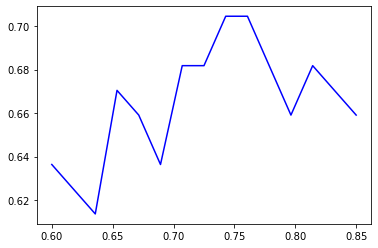

In [12]:

import time
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size = 0.8,random_state = 0)

print(X_train.shape)
print(X_test.shape)

def n_component_analysis(n, X, y_train, X_test, y_test):
    start = time.time()
    
    pca = PCA(n_components=n)
    print("PCA begin with n_components: {}".format(n));
    pca.fit(X_train)    
  
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)    

    clf2 = SVC(kernel='rbf',gamma=0.001,decision_function_shape='ovr',C=100,degree=1,probability=True)
    clf2.fit(X_train_pca, y_train)    

    accuracy = clf2.score(X_test_pca, y_test)
    
    end = time.time()
    print("accuracy: {}, time elaps:{}".format(accuracy, int(end-start)))
    return accuracy
 
n_s = np.linspace(0.60, 0.85, num=15)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n, X_train, y_train, X_test, y_test)
    accuracy.append(tmp)

print(max(accuracy), (accuracy.index(max(accuracy))*1)+1)                                 

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_s, np.array(accuracy), 'b-')

In [13]:
pca = PCA(n_components=0.7429)

pca.fit(X_train) 
pca.n_components_

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

clf2 = SVC(kernel='rbf',gamma=0.001,decision_function_shape='ovr',C=100,degree=1,probability=True)
clf2.fit(X_train_pca, y_train) 

y_predict = clf2.predict(X_test_pca)
clf2.score(X_test_pca, y_test) 


(350, 37)
(88, 37)


0.7045454545454546

### BayesSearchCV hyperparameter optimization

In [14]:
start=datetime.now()               

BayerSvcoptpca = BayesSearchCV(
    SVC(probability=True, random_state=42
    ),
    {
        
       'kernel': ['linear', 'poly', 'rbf'],
        'C':(1, 10),     
        'gamma': (0.01, 1),
          'degree':(1,10)

    },
 
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvcoptpca.fit(X_train_pca, y_train)
stop=datetime.now()

execution_time_svm1=(stop-start)
execution_time_svm1


datetime.timedelta(seconds=57, microseconds=268313)

In [15]:
print('Best parameters found by grid search are:', BayerSvcoptpca.best_params_)
print("val. score: %s" % BayerSvcoptpca.best_score_)

Best parameters found by grid search are: OrderedDict([('C', 1), ('degree', 1), ('gamma', 0.01), ('kernel', 'poly')])
val. score: -0.9026691576356205


In [16]:
svc0 = SVC(random_state=42
           ,C= 1
           ,kernel='poly'
           ,degree= 1
          ,gamma=0.01
          , probability=True)


In [17]:
# Same with the LGBM it doesn't work using BayesSearch Opitimization hyperparameter
#LGBM:(The score is lower than before,we can draw a conlusion,PCA don't need BayesSearch Opitimization hyperparameter)

svc0.fit(X_train_pca, y_train)
svc0.score(X_test_pca, y_test)

0.6818181818181818

In [18]:
clf2.fit(X_train_pca, y_train)
clf2.score(X_test_pca, y_test)

0.7045454545454546

## PCA----Random Forest

(350, 278)
(88, 278)
PCA begin with n_components: 0.4
accuracy: 0.6477272727272727, time elaps:0
PCA begin with n_components: 0.4392857142857143
accuracy: 0.6477272727272727, time elaps:0
PCA begin with n_components: 0.4785714285714286
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.5178571428571428
accuracy: 0.6022727272727273, time elaps:0
PCA begin with n_components: 0.5571428571428572
accuracy: 0.625, time elaps:0
PCA begin with n_components: 0.5964285714285714
accuracy: 0.6136363636363636, time elaps:0
PCA begin with n_components: 0.6357142857142857
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.675
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.7142857142857142
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_components: 0.7535714285714286
accuracy: 0.5909090909090909, time elaps:0
PCA begin with n_components: 0.7928571428571428
accuracy: 0.6363636363636364, time elaps:0
PCA begin with n_co

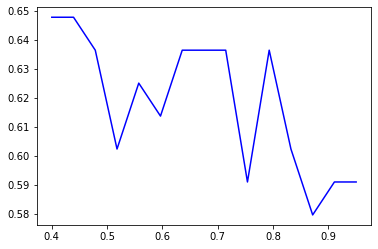

In [19]:
import time

X_train, X_test, y_train, y_test= train_test_split(X,y, train_size = 0.8,random_state = 0)
 

print(X_train.shape)
print(X_test.shape) 

def n_component_analysis(n, X, y_train, X_test, y_test):
    start = time.time()
    
    pca = PCA(n_components=n)
    print("PCA begin with n_components: {}".format(n));
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf3 = RFC()
    clf3.fit(X_train_pca, y_train)    

    accuracy = clf3.score(X_test_pca, y_test)
    
    end = time.time()
    print("accuracy: {}, time elaps:{}".format(accuracy, int(end-start)))
    return accuracy

n_s = np.linspace(0.40, 0.95, num=15)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n, X_train, y_train, X_test, y_test)
    accuracy.append(tmp)
    
print(max(accuracy), (accuracy.index(max(accuracy))*1)+1)    

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_s, np.array(accuracy), 'b-')

In [20]:
pca = PCA(n_components=0.4392)

pca.fit(X_train)
 
pca.n_components_ 

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape) 

clf3 =RFC()
clf3.fit(X_train_pca, y_train) 

y_predict = clf3.predict(X_test_pca)
clf3.score(X_test_pca, y_test) 


(350, 11)
(88, 11)


0.6477272727272727

### BayesSearchCV hyperparameter optimization

In [21]:
rf = RFC(random_state=42)


BayerRfoptpca = BayesSearchCV(
   rf,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerRfoptpca.fit(X_train_pca, y_train)
print('Best parameters found by grid search are:', BayerRfoptpca.best_params_)

Best parameters found by grid search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'log2'), ('n_estimators', 50)])


In [22]:
print("val. score: %s" % BayerRfoptpca.best_score_)
# print("test score: %s" % BayerRfoptpca.score(X_test_pca, y_test))

val. score: -1.0558900401458025


In [23]:
rf1 = RFC(random_state=42, max_features='log2', n_estimators= 50,
                                     max_depth=6, 
                                     criterion='entropy')

In [24]:
# Same with the LGBM it doesn't work using BayesSearch Opitimization hyperparameter
#LGBM:(The score is lower than before,we can draw a conlusion,PCA don't need BayesSearch Opitimization hyperparameter)
rf1.fit(X_train_pca, y_train)
rf1.score(X_test_pca, y_test)

0.625

## Explore the fixed number of features

In [25]:
pca = PCA(n_components=28)
pcamodel = pca.fit(X)
print("Explained Variance: %s") 
print(pcamodel.components_)

Explained Variance: %s
[[ 0.06733517 -0.0190863   0.00172037 ... -0.09143465 -0.08669271
  -0.13048273]
 [ 0.0588845   0.00846249 -0.03677794 ... -0.08231382  0.18555138
   0.06689478]
 [-0.01025248 -0.04559551  0.02093735 ... -0.06236845 -0.01860156
  -0.06031889]
 ...
 [-0.06119366  0.01752234 -0.12670568 ... -0.03132471 -0.00462475
  -0.02477632]
 [ 0.00231934  0.03845928  0.0033915  ... -0.01321075 -0.00835314
  -0.01690061]
 [-0.00547491  0.01549505  0.02001302 ...  0.01653145 -0.0152488
  -0.00528646]]


In [26]:
newMat=pcamodel.fit_transform(X) 
X_pca = DataFrame(newMat)
X3_train, X3_test,y3_train,y3_test= train_test_split(X_pca,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)


In [27]:
classifier_lgbm_pca=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=3, num_leaves=8,
                                learning_rate=0.01,n_estimators=268,
                                colsample_bytree= 0.6413,subsample= 0.8)
# LGBMClassifier(boosting_type='gbdt',objective ='multiclass',max_depth=4, num_leaves=300,learning_rate=0.01,n_estimators=150,class_weight = "balanced")
classifier_svm_pca=SVC(kernel='rbf',gamma=0.001,decision_function_shape='ovr',C=100,degree=1,probability=True)
# SVC(probability=True, random_state=42
#           ,C=6
#            ,degree= 1
#            ,gamma= 0.01
#            ,kernel='rbf')
classifier_rf_pca= RFC(random_state=42, max_features='log2', n_estimators= 150,
                                     max_depth=11, 
                                     criterion='gini')

start=datetime.now()
classifier_lgbm_pca.fit(X3_train,y3_train.ravel())
stop=datetime.now()
execution_time_svm=stop-start
print("LGBM execution time is:",execution_time_svm)


start=datetime.now()
classifier_svm_pca.fit(X3_train,y3_train.ravel())
stop=datetime.now()
execution_time_svm=stop-start
print("SVM execution time is:",execution_time_svm)

classifier_rf_pca.fit(X3_train,y3_train.ravel())

#prediction on test data
y_pred_lgbm=classifier_lgbm_pca.predict(X3_test)
y_pred_svm=classifier_svm_pca.predict(X3_test)
y_pred_rf=classifier_rf_pca.predict(X3_test)
# y2_pred_svm=[list(x).index(max(x))for x in y2_pred_svm]

print(classification_report(y3_test, y_pred_lgbm,zero_division=1))
print(classification_report(y3_test, y_pred_svm,zero_division=1))
print(classification_report(y3_test, y_pred_rf,zero_division=1))

LGBM execution time is: 0:00:00.385375
SVM execution time is: 0:00:00.060209
              precision    recall  f1-score   support

           0       0.64      0.96      0.77        49
           1       0.67      0.44      0.53         9
           2       1.00      0.67      0.80         3
           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         3
           5       1.00      0.00      0.00         5
           6       1.00      1.00      1.00         2
           7       0.67      0.20      0.31        10
           8       1.00      0.00      0.00         4

    accuracy                           0.66        88
   macro avg       0.78      0.40      0.43        88
weighted avg       0.70      0.66      0.59        88

              precision    recall  f1-score   support

           0       0.74      0.86      0.79        49
           1       0.50      0.67      0.57         9
           2       0.75      1.00      0.86         3
 

In [28]:
BayerLgbmoptpca = BayesSearchCV(
     classifier_lgbm_pca,
     {    
     
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
    } ,
     n_iter=50,
     cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmoptpca.fit(X3_train, y3_train)



BayesSearchCV(cv=5,
              estimator=LGBMClassifier(colsample_bytree=0.6413,
                                       learning_rate=0.01, max_depth=3,
                                       n_estimators=268, num_leaves=8,
                                       objective='multiclass', subsample=0.8),
              n_points=2, random_state=42, scoring='neg_log_loss',
              search_spaces={'colsample_bytree': (0.5, 0.8),
                             'learning_rate': (0.005, 0.01, 0.001),
                             'max_depth': (3, 8), 'n_estimators': (100, 300),
                             'num_leaves': (8, 170), 'subsample': (0.5, 0.8)})

In [29]:
print('Best parameters found by grid search are:', BayerLgbmoptpca.best_params_)
print("val. score: %s" % BayerLgbmoptpca.best_score_)
print("test score: %s" % BayerLgbmoptpca.score(X3_test, y3_test))

Best parameters found by grid search are: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 269), ('num_leaves', 135), ('subsample', 0.8)])
val. score: -1.0255600445191877
test score: -1.1703930730237602


In [30]:
lgbm1=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=3, num_leaves=135,
                                learning_rate=0.01,n_estimators=269,
                                colsample_bytree= 0.5,subsample= 0.8)

In [31]:
lgbm_arrhthpca=lgbm1.fit(X3_train,y3_train)
y_pred_lgbm1=lgbm1.predict((X3_test))
y_prob_lgbm1=lgbm1.predict_proba((X3_test))
print("Accuracy score with LGBM is: ",accuracy_score(y3_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y3_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y3_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y3_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y3_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.6590909090909091
F1 score with LGBM is:  0.6590909090909091
ROC_AUC score with LGBM is:  0.7761347176325033
Cross entropy loss score with LGBM is:  1.1703930730237602
